# L4: Predictions, Prompts and Safety

- Load the Project ID and credentials.

In [5]:
from utils import authenticate
credentials, PROJECT_ID = authenticate() 

In [6]:
REGION = "us-central1"

- Import the [Vertex AI](https://cloud.google.com/vertex-ai) SDK.
- Import and load the model.
- Initialize it.

In [7]:
import vertexai
from vertexai.language_models import TextGenerationModel

In [4]:
vertexai.init(project = PROJECT_ID,
              location = REGION,
              credentials = credentials)

## Deployment

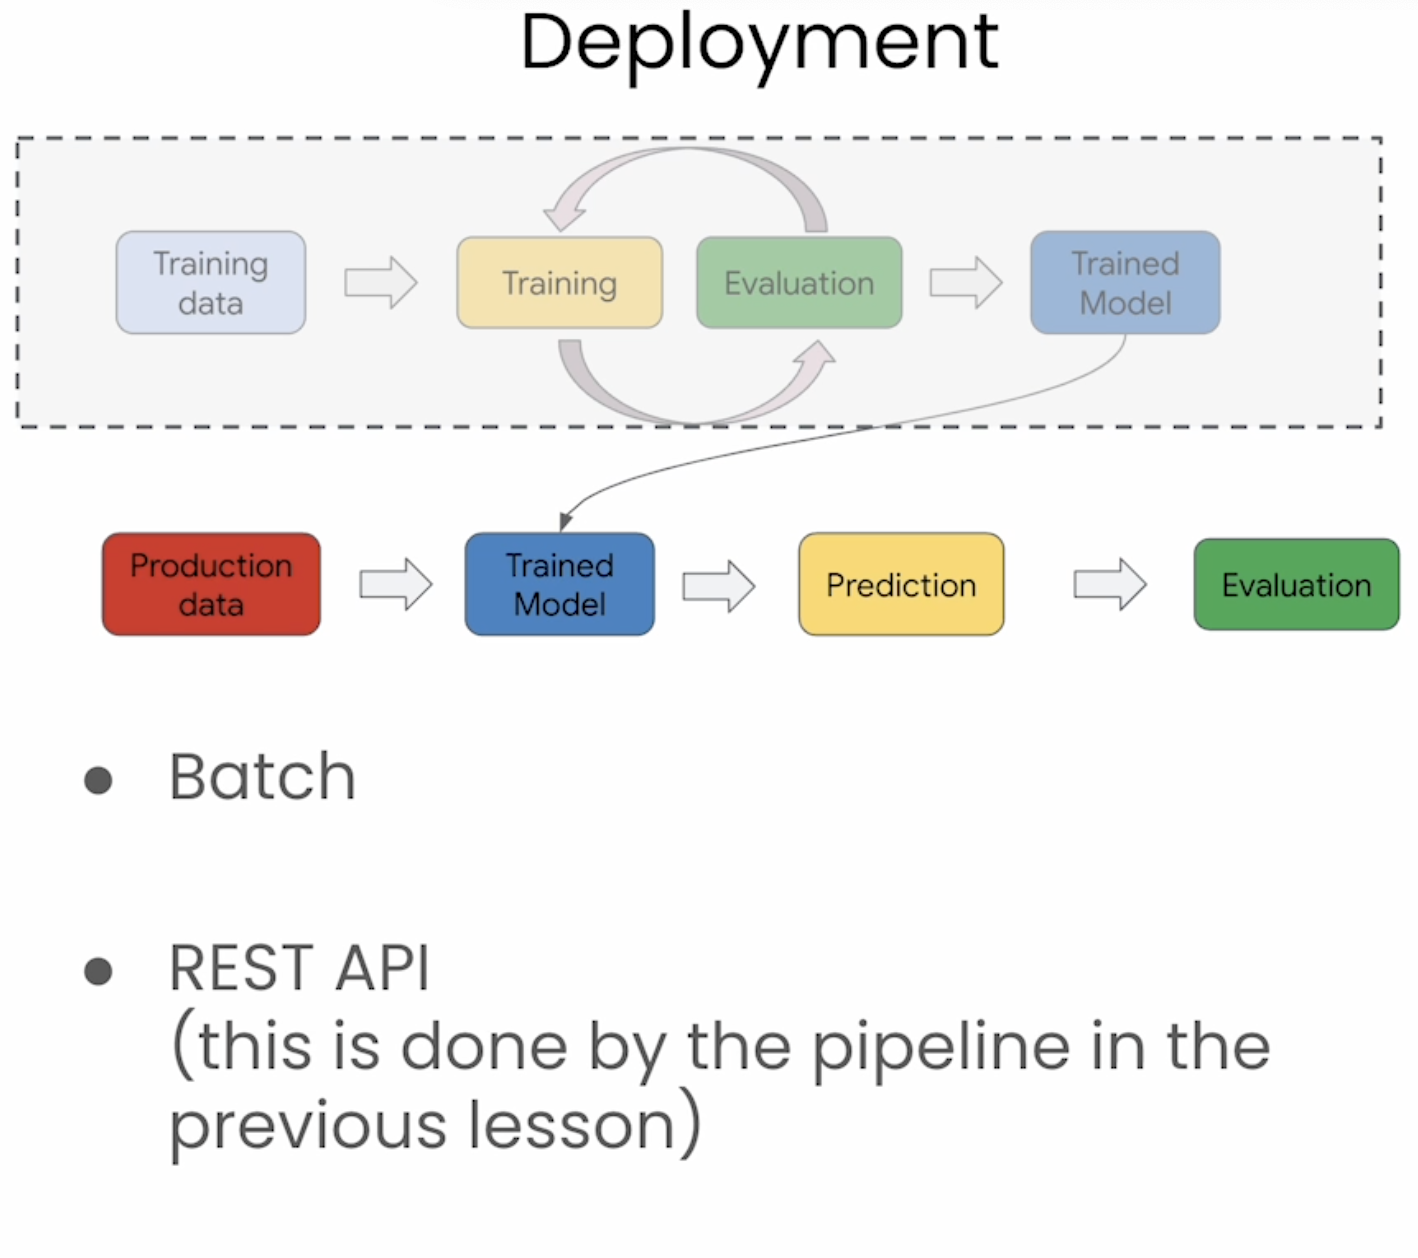

- Batch - not ideal for real-time use cases. example: customer feedback analysis

- REST API - model is deployed as an API, its online and you can use it as a service. Ideal for real-time use cases. (take the trained model -> packaged it up in a container as a RESTAPI -> you can take a production data -> send that to API -> to get the predictions.

### Load Balancing

- Load from pre-trained `text-bison@001`
- Retrieve the endpoints (deployed as REST API)

In [8]:
model = TextGenerationModel.from_pretrained("text-bison@001")

- Get the list of multiple models executed and deployed.
- This helps to rout the traffic to different endpoints.

In [9]:
list_tuned_models = model.list_tuned_model_names()

In [10]:
for i in list_tuned_models:
    print (i)

projects/71361331534/locations/us-central1/models/6370255124683022336
projects/71361331534/locations/us-central1/models/4167964906898849792
projects/71361331534/locations/us-central1/models/5796209686239772672


- Randomly select from one of the endpoints to divide the prediction load.

In [11]:
import random

In [12]:
tuned_model_select = random.choice(list_tuned_models)

### Getting the Response

- Load the endpoint of the randomly selected model to be called with a prompt.
- The prompt needs to be as similar as possible as the one you trained your model on (python questions from stack overflow dataset)

In [13]:
deployed_model = TextGenerationModel.get_tuned_model\
(tuned_model_select)

In [14]:
PROMPT = "How can I load a csv file using Pandas?"

- Use `deployed_model.predit` to call the API using the prompt. 

In [15]:
### depending on the latency of your prompt
### it can take some time to load
response = deployed_model.predict(PROMPT)

In [16]:
print(response)

MultiCandidateTextGenerationResponse(text='To load a CSV file using Pandas, you can use the `read_csv()` function. This function takes the path to the CSV file as its first argument. You can also specify a number of other arguments, such as the delimiter, the header row, and the index column.\n\nFor example, the following code loads the `data.csv` file and stores it in a DataFrame named `df`:\n\n```\ndf = pd.read_csv("data.csv")\n```\n\nYou can then access the data in the DataFrame using the `loc()` and `iloc()` methods.', _prediction_response=Prediction(predictions=[{'content': 'To load a CSV file using Pandas, you can use the `read_csv()` function. This function takes the path to the CSV file as its first argument. You can also specify a number of other arguments, such as the delimiter, the header row, and the index column.\n\nFor example, the following code loads the `data.csv` file and stores it in a DataFrame named `df`:\n\n```\ndf = pd.read_csv("data.csv")\n```\n\nYou can then ac

- `pprint` makes the response easily readable.

In [17]:
from pprint import pprint

- Sending multiple prompts can return multiple responses `([0], [1], [2]...)`
- In this example, only 1 prompt is being sent, and returning only 1 response `([0])`

In [18]:
### load the first object of the response
output = response._prediction_response[0]

In [19]:
### print the first object of the response
pprint(output)

[{'citationMetadata': {'citations': []},
  'content': 'To load a CSV file using Pandas, you can use the `read_csv()` '
             'function. This function takes the path to the CSV file as its '
             'first argument. You can also specify a number of other '
             'arguments, such as the delimiter, the header row, and the index '
             'column.\n'
             '\n'
             'For example, the following code loads the `data.csv` file and '
             'stores it in a DataFrame named `df`:\n'
             '\n'
             '```\n'
             'df = pd.read_csv("data.csv")\n'
             '```\n'
             '\n'
             'You can then access the data in the DataFrame using the `loc()` '
             'and `iloc()` methods.',
  'safetyAttributes': {'blocked': False,
                       'categories': ['Finance',
                                      'Insult',
                                      'Politics',
                                      'Sexual']

In [20]:
### load the second object of the response
output = response._prediction_response[0][0]

In [21]:
### print the second object of the response
pprint(output)

{'citationMetadata': {'citations': []},
 'content': 'To load a CSV file using Pandas, you can use the `read_csv()` '
            'function. This function takes the path to the CSV file as its '
            'first argument. You can also specify a number of other arguments, '
            'such as the delimiter, the header row, and the index column.\n'
            '\n'
            'For example, the following code loads the `data.csv` file and '
            'stores it in a DataFrame named `df`:\n'
            '\n'
            '```\n'
            'df = pd.read_csv("data.csv")\n'
            '```\n'
            '\n'
            'You can then access the data in the DataFrame using the `loc()` '
            'and `iloc()` methods.',
 'safetyAttributes': {'blocked': False,
                      'categories': ['Finance', 'Insult', 'Politics', 'Sexual'],
                      'safetyRatings': [{'category': 'Dangerous Content',
                                         'probabilityScore': 0.1,
     

In [22]:
### retrieve the "content" key from the second object
final_output = response._prediction_response[0][0]["content"]

In [23]:
### printing "content" key from the second object
print(final_output)

To load a CSV file using Pandas, you can use the `read_csv()` function. This function takes the path to the CSV file as its first argument. You can also specify a number of other arguments, such as the delimiter, the header row, and the index column.

For example, the following code loads the `data.csv` file and stores it in a DataFrame named `df`:

```
df = pd.read_csv("data.csv")
```

You can then access the data in the DataFrame using the `loc()` and `iloc()` methods.


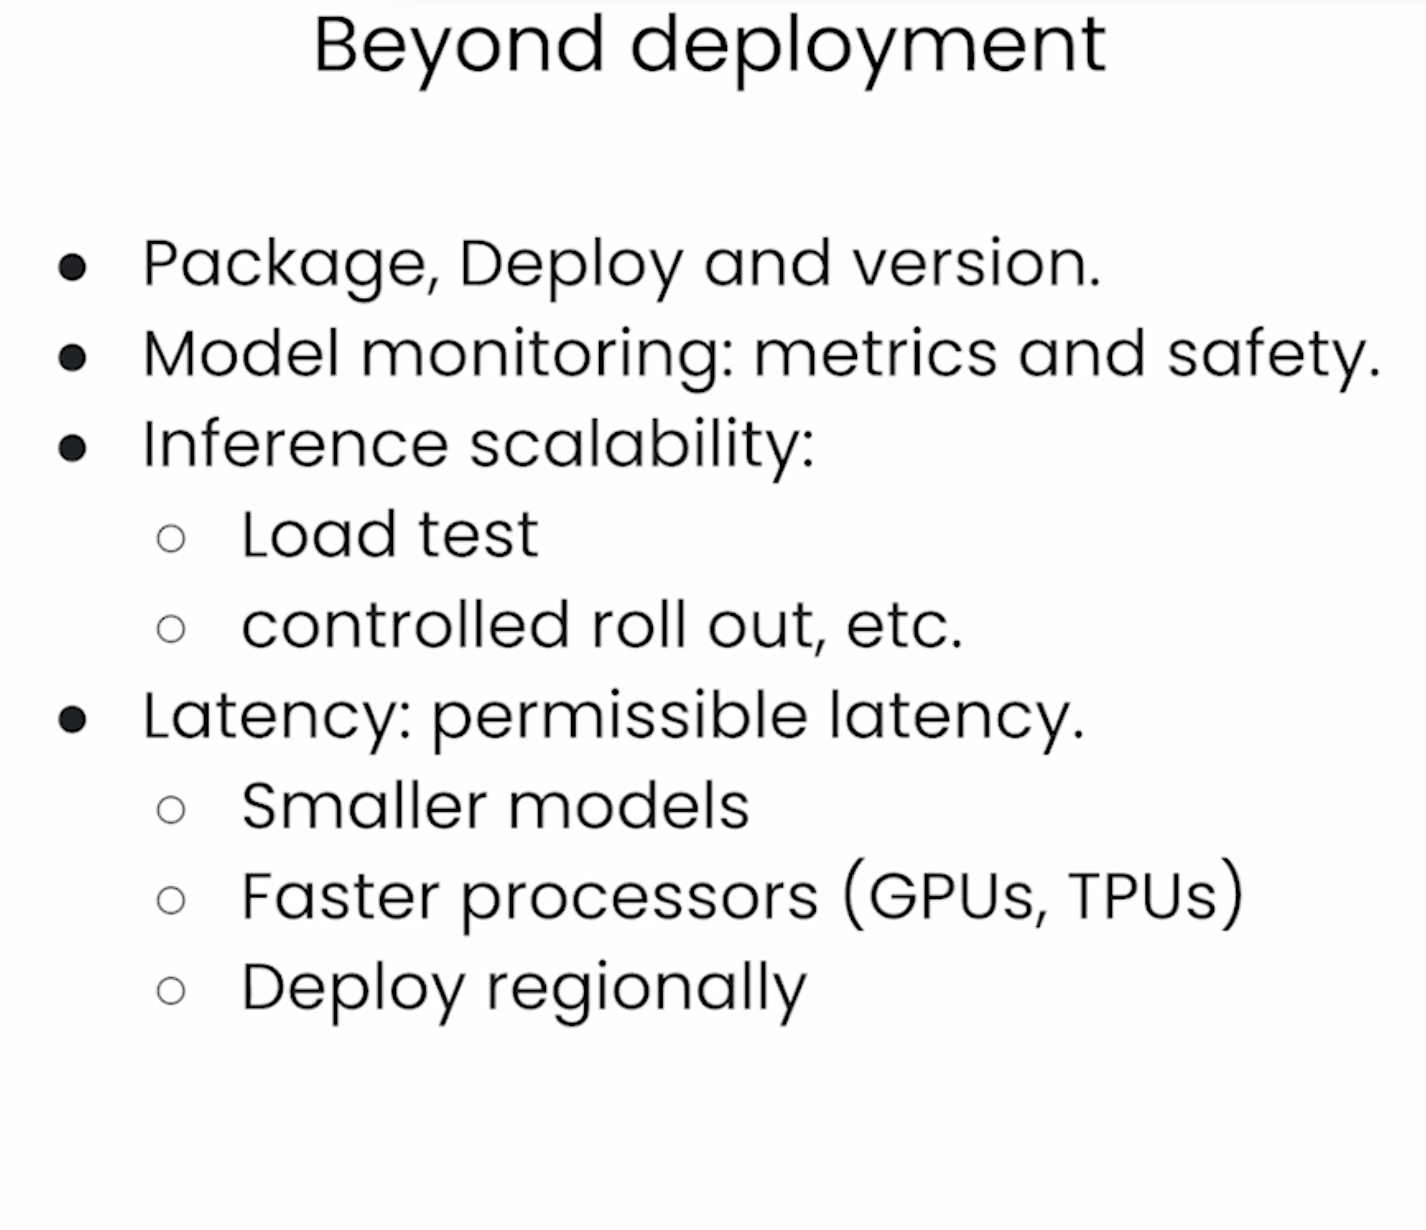

#### Prompt Management and Templates
- Remember that the model was trained on data that had an `Instruction` and a `Question` as a `Prompt` (Lesson 2).
- In the example above, *only*  a `Question` as a `Prompt` was used for a response.
- It is important for the production data to be the same as the training data. Difference in data can effect the model performance.
- Add the same `Instruction` as it was used for training data, and combine it with a `Question` to be used as a `Prompt`.

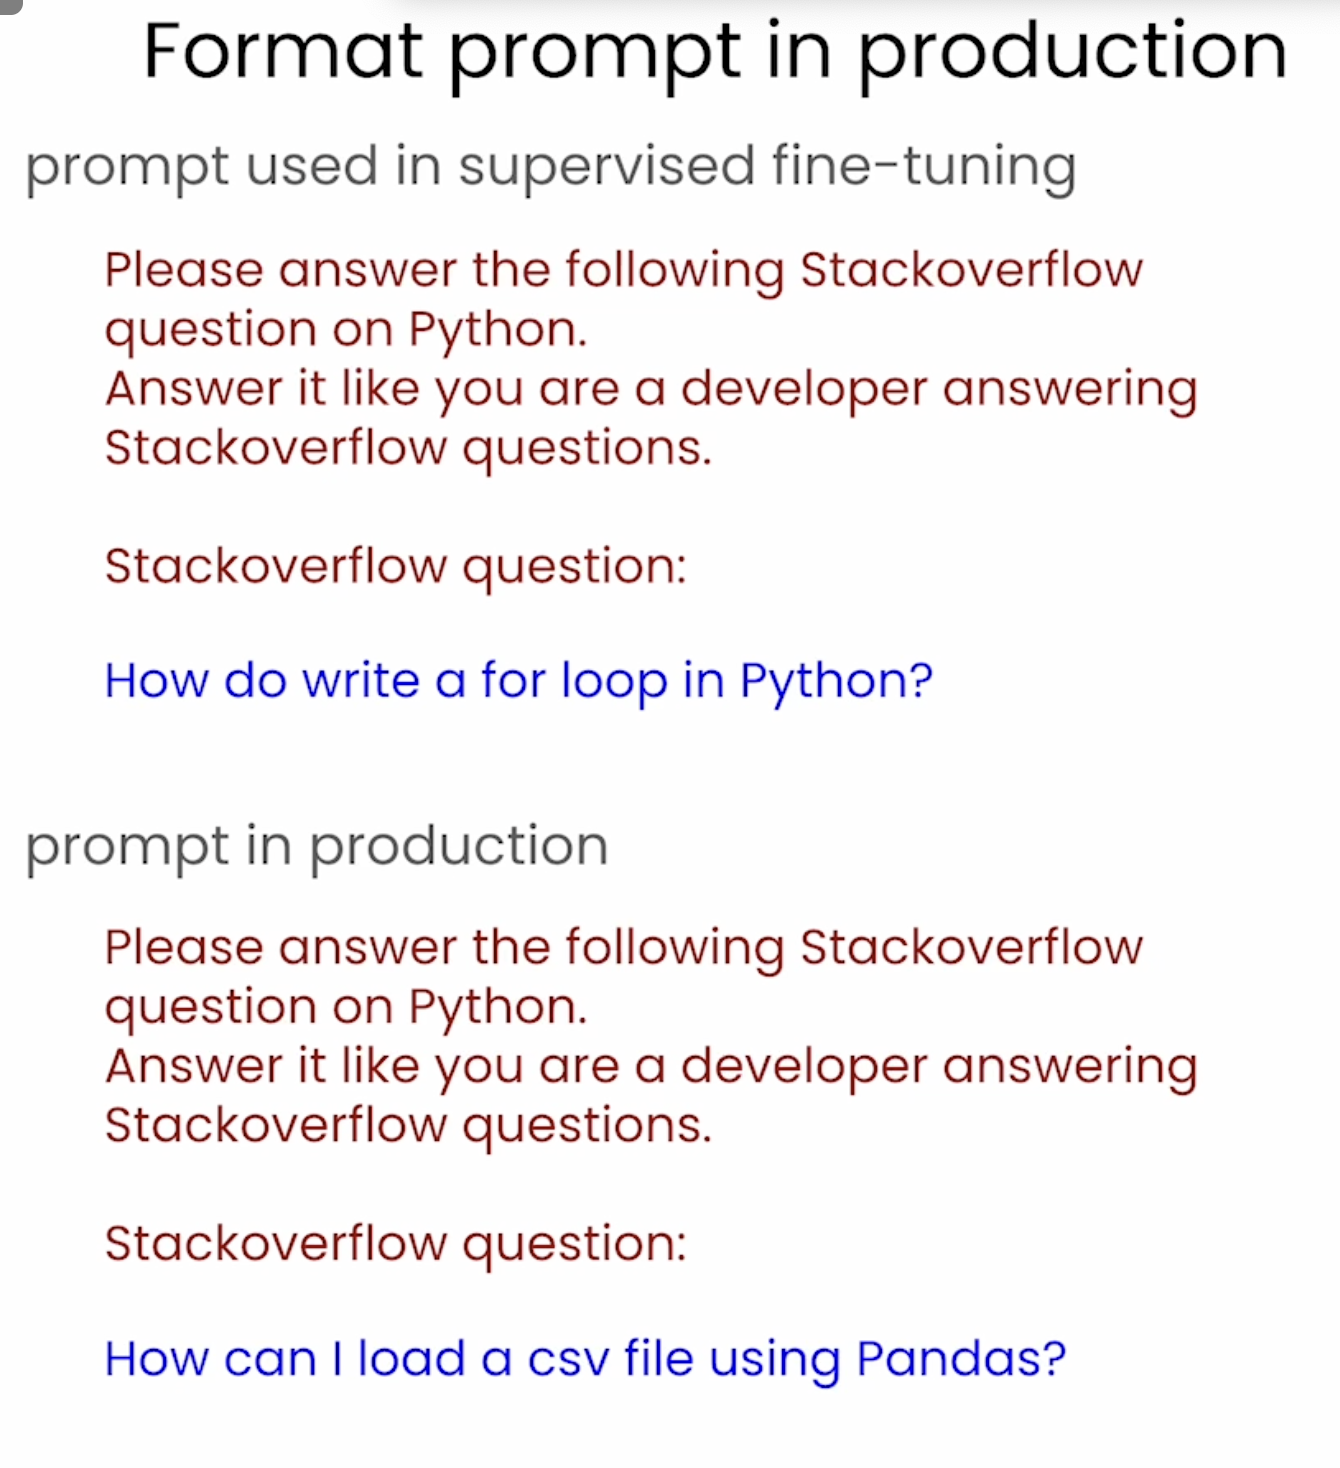

In [24]:
INSTRUCTION = """\
Please answer the following Stackoverflow question on Python.\
Answer it like\
you are a developer answering Stackoverflow questions.\
Question:
"""

In [25]:
QUESTION = "How can I store my TensorFlow checkpoint on\
Google Cloud Storage? Python example?"

- Combine the intruction and the question to create the prompt.

In [26]:
PROMPT = f"""
{INSTRUCTION} {QUESTION}
"""

In [27]:
print(PROMPT)


Please answer the following Stackoverflow question on Python.Answer it likeyou are a developer answering Stackoverflow questions.Question:
 How can I store my TensorFlow checkpoint onGoogle Cloud Storage? Python example?



- Get the response using the new prompt, which is consistent with the prompt used for training.

In [28]:
final_response = deployed_model.predict(PROMPT)

In [29]:
output = final_response._prediction_response[0][0]["content"]

- Note how the response changed from earlier.

In [30]:
print(output)

To store your TensorFlow checkpoint on Google Cloud Storage, you can use the `tf.io.gfile.GFile` class. This class provides a way to read and write files to Google Cloud Storage.

To save a checkpoint to Google Cloud Storage, you can use the following code:

```python
import tensorflow as tf
from tensorflow.io import gfile

# Create a checkpoint directory in Google Cloud Storage.
checkpoint_dir = gfile.GFile('gs://my-bucket/my-checkpoint-dir', 'w')

# Save the checkpoint to Google


### Safety Attributes
- The reponse also includes safety scores.
- These scores can be used to make sure that the LLM's response is within the boundries of the expected behaviour.
- The first layer for this check, `blocked`, is by the model itself.

In [31]:
### retrieve the "blocked" key from the 
### "safetyAttributes" of the response
blocked = response._prediction_response[0][0]\
['safetyAttributes']['blocked']

- Check to see if any response was blocked.
- It returns `True` if there is, and `False` if there's none.

In [32]:
print(blocked)

False


- The second layer of this check can be defined by you, as a practitioner, according to the thresholds you set.
- The response returns probabilities for each safety score category which can be used to design the thresholds.

In [33]:
### retrieve the "safetyAttributes" of the response
safety_attributes = response._prediction_response[0][0]\
['safetyAttributes']

In [34]:
pprint(safety_attributes)

{'blocked': False,
 'categories': ['Finance', 'Insult', 'Politics', 'Sexual'],
 'safetyRatings': [{'category': 'Dangerous Content',
                    'probabilityScore': 0.1,
                    'severity': 'NEGLIGIBLE',
                    'severityScore': 0.1},
                   {'category': 'Harassment',
                    'probabilityScore': 0.1,
                    'severity': 'NEGLIGIBLE',
                    'severityScore': 0.1},
                   {'category': 'Hate Speech',
                    'probabilityScore': 0.0,
                    'severity': 'NEGLIGIBLE',
                    'severityScore': 0.1},
                   {'category': 'Sexually Explicit',
                    'probabilityScore': 0.1,
                    'severity': 'NEGLIGIBLE',
                    'severityScore': 0.0}],
 'scores': [0.6, 0.1, 0.2, 0.1]}


### Citations
- Ideally, a LLM should generate as much original cotent as possible.
- The `citationMetadata` can be used to check and reduce the chances of a LLM generating a lot of existing content.

In [35]:
### retrieve the "citations" key from the 
### "citationMetadata" of the response
citation = response._prediction_response[0][0]\
['citationMetadata']['citations']

- Returns a list with information if the response is cited, if not, then it retuns an empty list.

In [36]:
pprint(citation)

[]


## Try it Yourself! - Return a Citation

Now it is time for you to come up with an example, for which the model response should return citation infomration. The idea here is to see how that would look like, so keeping it basic, the prompt can be different than the coding examples used above. Below code is one such prompt:

In [37]:
PROMPT = "Finish the sentence: To be, or not "

In [38]:
response = deployed_model.predict(PROMPT)

In [39]:
### output of the model
output = response._prediction_response[0][0]["content"]
print(output)

To be, or not to be, that is the question: Whether 'tis nobler in the mind to suffer The slings and arrows of outrageous fortune, Or to take arms against a sea of troubles, And by opposing end them?


In [40]:
### check for citation
citation = response._prediction_response[0][0]\
['citationMetadata']['citations']

pprint(citation)

[]


**Your turn!**

### Optional Notebook

[Tuning and deploy a foundation model](https://github.com/GoogleCloudPlatform/generative-ai/blob/main/language/tuning/tuning_text_bison.ipynb)